In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model



In [ ]:
data = pd.read_csv('./data/labeled_data.csv', index_col=0)
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
data.rename(columns={'class':'label'}, inplace=True)

In [ ]:
data['label'].value_counts()

In [ ]:
data.head()

In [ ]:
# Drop count, hate_speech, offensive_language and neither columns
data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1, inplace=True)

# 0: 'hate_speech', 1: 'offensive_language',2: 'neither'

data.head()


# Data Preprocessing

In [ ]:
# Remove all non-ASCII characters
data['tweet'] = data['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

In [ ]:
# Remove all URLs, replace by URL
data['tweet'] = data['tweet'].str.replace('http\S+|www.\S+', 'URL', case=False)

In [ ]:
# Remove all punctuations
data['tweet'] = data['tweet'].str.replace('[^\w\s]', ' ')

In [ ]:
# Remove all digits
data['tweet'] = data['tweet'].str.replace('\d+', ' ')

In [ ]:
# Remove all single characters
data['tweet'] = data['tweet'].str.replace('\s+[a-zA-Z]\s+', ' ')

In [ ]:
# Remove single characters from the start
data['tweet'] = data['tweet'].str.replace('\^[a-zA-Z]\s+', ' ')

In [ ]:
# Lowercase all text
data['tweet'] = data['tweet'].str.lower()

In [ ]:
# Remove all whitespaces
data['tweet'] = data['tweet'].str.replace('\s+', ' ')

In [ ]:
# Remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

data['tweet'] = data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [ ]:
# Remove all words with 2 or fewer letters
data['tweet'] = data['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [ ]:
data.head()

# Splitting the data

In [ ]:
X = data['tweet']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

# Word Cloud

In [ ]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in X_train])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Word cloud for hate speech
hate_words = ' '.join([text for text in X_train[y_train==0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hate_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Word cloud for offensive language
offensive_words = ' '.join([text for text in X_train[y_train==1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(offensive_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
# Word cloud for neither
neither_words = ' '.join([text for text in X_train[y_train==2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neither_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

print(X_train[2])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

print(X_train[0, :])

# Building the model

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 100


model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=3, validation_data=(X_val, y_val))

248/248 [==============================] - 73s 282ms/step - loss: 0.6989 - accuracy: 0.7712 - val_loss: 0.6538 - val_accuracy: 0.7809
Epoch 2/3
248/248 [==============================] - 69s 280ms/step - loss: 0.6851 - accuracy: 0.7746 - val_loss: 0.6585 - val_accuracy: 0.7809
Epoch 3/3
248/248 [==============================] - 69s 279ms/step - loss: 0.6797 - accuracy: 0.7746 - val_loss: 0.6560 - val_accuracy: 0.7809


In [ ]:
# Plotting the training and validation accuracy and loss

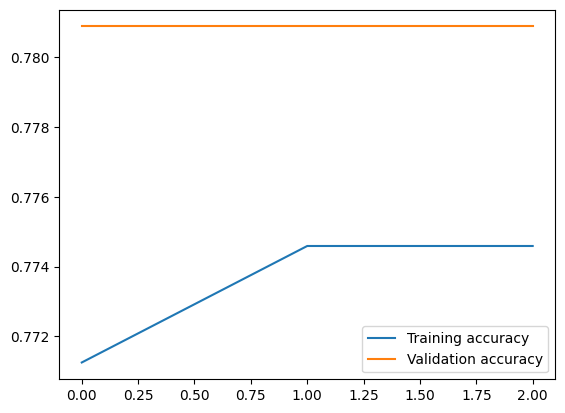

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

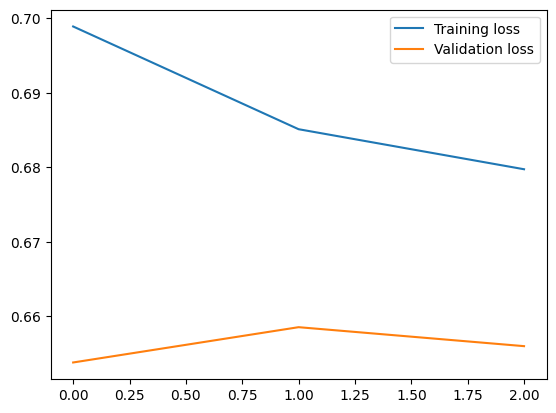

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
# Evaluating the model

In [ ]:
def evaluate_model(X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Accuracy: %f' % (accuracy*100))
    print('Loss: %f' % (loss*100))

In [ ]:
evaluate_model(X_test, y_test)

Accuracy: 76.820660
Loss: 67.251199


In [ ]:
# Making predictions

In [103]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9]+', '', text)
    text = re.sub(r'#[a-zA-Z0-9]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


In [104]:
def predict_sentiment(text):
    sentiment = ['Hate Speech', 'Offensive Language', 'Neither']
    text = clean_text(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, padding='post', maxlen=maxlen)
    prediction = model.predict(text)
    print(sentiment[np.argmax(prediction)])

In [105]:
predict_sentiment('I hate you')

1/1 [==============================] - 1s 748ms/step
Offensive Language


In [106]:
predict_sentiment('I love you')

1/1 [==============================] - 0s 28ms/step
Offensive Language
